# SHAP Values Review

Os valores SHAP mostram o quanto um determinado recurso mudou nossa previsão (em comparação se tivéssemos feito essa previsão em algum valor de baseline desse recurso).

Por exemplo, considere um modelo simples:
    $$y = 4 * x1 + 2 * x2$$

Se $x1$ recebe o valor 2, em vez de um valor baseline de 0, então nosso valor de SHAP para $x1$ seria 8 (4 vezes 2).

Esses são mais difíceis de calcular com os modelos sofisticados que usamos na prática. Mas, por meio de alguma inteligência algorítmica, os valores de Shap nos permitem decompor qualquer previsão na soma dos efeitos de cada valor de recurso, produzindo um gráfico como este:

![Imgur](https://i.imgur.com/JVD2U7k.png)

[Link para ver a imagem maior](https://i.imgur.com/JVD2U7k.png)*

Além desse bom detalhamento para cada previsão, a [biblioteca Shap] (https://github.com/slundberg/shap) oferece ótimas visualizações de grupos de valores Shap. Vamos nos concentrar em duas dessas visualizações. Essas visualizações têm semelhanças conceituais com a importância da permutação e gráficos de dependência parcial.

# Plotagens de resumo

[Importância da permutação] (https://github.com/brunobarella/Permutation_Importance_eli5) é ótimo porque criou medidas numéricas simples para ver quais recursos importavam para um modelo. Isso nos ajudou a fazer comparações entre recursos facilmente e você pode apresentar os gráficos resultantes para públicos não técnicos.

Mas não diz como cada recurso é importante. Se um recurso tem importância de permutação média, isso pode significar que ele tem
- um grande efeito para algumas previsões, mas nenhum efeito em geral, ou
- um efeito médio para todas as previsões.

Os gráficos de resumo do SHAP nos dão uma visão panorâmica da importância do recurso e o que o está impulsionando. Examinaremos um exemplo de gráfico para os dados do futebol:

![Imgur](https://i.imgur.com/Ew9X3su.png)

Este gráfico é feito de muitos pontos. Cada ponto possui três características:
- A localização vertical mostra o recurso que está representando
- A cor mostra se esse recurso era alto ou baixo para aquela linha do conjunto de dados
- A localização horizontal mostra se o efeito daquele valor causou uma previsão mais alta ou mais baixa.

Por exemplo, o ponto superior esquerdo foi para uma equipe que marcou poucos gols, reduzindo a previsão em 0,25.

Algumas coisas que você deve saber facilmente:
- O modelo ignorou os recursos `Red` e `Yellow & Red`.
- Normalmente, o `cartão amarelo` não afeta a previsão, mas há um caso extremo em que um valor alto causou uma previsão muito menor.
- Altos valores de gol marcados causaram previsões mais altas, e valores baixos causaram previsões baixas

Se você olhar por tempo suficiente, há muitas informações neste gráfico.

In [2]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier

data = pd.read_csv('FIFA 2018 Statistics.csv')
y = (data['Man of the Match'] == "Yes")  # Convert from string "Yes"/"No" to binary
feature_names = [i for i in data.columns if data[i].dtype in [np.int64, np.int64]]
X = data[feature_names]
train_X, val_X, train_y, val_y = train_test_split(X, y, random_state=1)
my_model = RandomForestClassifier(random_state=0).fit(train_X, train_y)

Obtemos os valores SHAP para todos os dados de validação com o código a seguir. É curto o suficiente para ser explicado nos comentários.

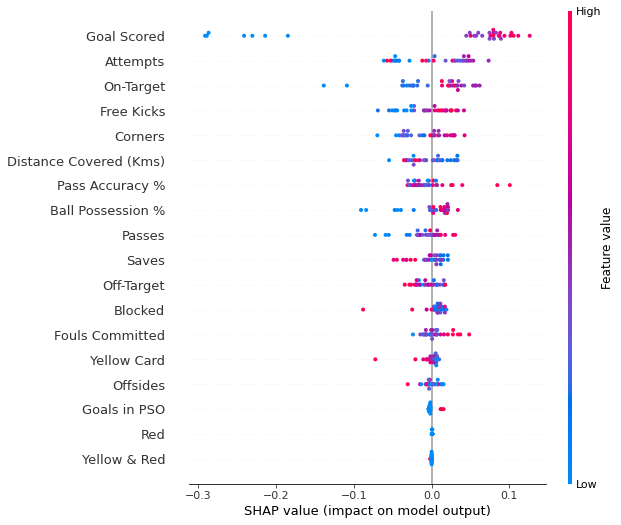

In [3]:
import shap  # pacote usado para calcular os SHAP values

# Criando um objeto que calcula os SHAP values
explainer = shap.TreeExplainer(my_model)

# Calculando os SHAP values. Isto que sera plotado.
# Calculando shap_values para todos val_X em vez de uma única linha, para ter mais dados para o gráfico.
shap_values = explainer.shap_values(val_X)

# Fazendo o plot. O índice de [1] é explicado no texto abaixo.
shap.summary_plot(shap_values[1], val_X)

O código não é muito complexo. Mas existem algumas ressalvas.

- Ao plotar, chamamos `shap_values ​[1]`. Para problemas de classificação, há uma matriz separada de valores SHAP para cada resultado possível. Nesse caso, indexamos [1] para obter os valores de SHAP para a previsão de "Verdadeiro".
- O cálculo dos valores de SHAP pode ser lento. Não é um problema aqui, porque este conjunto de dados é pequeno. Mas você deve ter cuidado ao executá-los para plotar com conjuntos de dados de tamanhos razoáveis. A exceção é quando se usa um modelo `xgboost` ou modelos de arvores, para o qual o SHAP possui algumas otimizações e, portanto, é muito mais rápido.

Isso fornece uma ótima visão geral do modelo, mas podemos querer nos aprofundar em um único recurso. É aí que entram em jogo os gráficos de contribuição de dependência do SHAP.

# Parcelas de contribuição de dependência SHAP

Anteriormente, usamos gráficos de dependência parcial para mostrar como um único recurso afeta as previsões. Eles são perspicazes e relevantes para muitos casos de uso do mundo real. Além disso, com um pouco de esforço, eles podem ser explicados a um público não técnico.

Mas há muito que eles não mostram. Por exemplo, qual é a distribuição dos efeitos? O efeito de ter um determinado valor é bastante constante ou varia muito dependendo dos valores de outros recursos? Os gráficos de contribuição de dependência do SHAP fornecem uma visão semelhante aos PDP, mas acrescentam muito mais detalhes.

![Imgur](https://i.imgur.com/uQ2JmBm.png)

Comece focalizando a forma e voltaremos a colorir em um minuto. Cada ponto representa uma linha dos dados. A localização horizontal é o valor real do conjunto de dados e a localização vertical mostra o que esse valor fez com a previsão. O fato de esta ser inclinada para cima indica que quanto mais você possui a bola, maior é a previsão do modelo para ganhar o prêmio de * Jogador em Campo *.

O spread sugere que outros recursos devem interagir com% de posse de bola. Por exemplo, aqui destacamos dois pontos com valores de posse de bola semelhantes. Esse valor fez com que uma predição aumentasse e que a outra diminuísse.

![Imgur](https://i.imgur.com/tFzp6jc.png)

Para efeito de comparação, uma regressão linear simples produziria gráficos que são linhas perfeitas, sem esse spread.

Isso sugere que investiguemos as interações e os gráficos incluem códigos de cores para ajudar a fazer isso. Embora a tendência primária seja de alta, você pode inspecionar visualmente se isso varia de acordo com a cor do ponto.

Considere o seguinte exemplo muito restrito de concretude.

![Imgur](https://i.imgur.com/NVB3eNW.png)

Esses dois pontos se destacam espacialmente por estarem distantes da tendência de alta. Ambos são de cor roxa, indicando que o time marcou um gol. Você pode interpretar isso como ** Em geral, ter a bola aumenta a chance de um time de ter seu jogador ganhando o prêmio. Mas se eles marcarem apenas um gol, essa tendência se inverte e os juízes de premiação podem penalizá-los por terem tanto a bola se marcarem tão pouco.

Fora desses poucos outliers, a interação indicada pela cor não é muito dramática aqui. Mas às vezes ele vai saltar para você.

# Parcelas de contribuição de dependência no código
Obtemos o gráfico de contribuição de dependência com o código a seguir. A única linha diferente de `summary_plot` é a última linha.

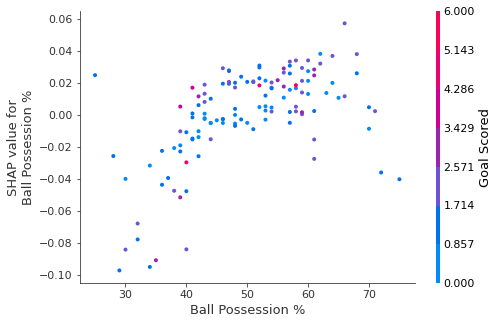

In [3]:
import shap  

explainer = shap.TreeExplainer(my_model)

shap_values = explainer.shap_values(X)

shap.dependence_plot('Ball Possession %', shap_values[1], X, interaction_index="Goal Scored")

Se você não fornecer um argumento para `interação_index`, Shapley usa alguma lógica para escolher um que pode ser interessante.

Isso não exigiu a escrita de muito código. Mas o truque com essas técnicas é pensar criticamente sobre os resultados, em vez de escrever o próprio código.